# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.658554,False,1.554445
1,0.296818,True,5.784714
2,-2.402264,False,-0.765250
3,-0.588699,False,-1.197277
4,-1.090333,False,-0.501680
...,...,...,...
995,-1.067696,False,-1.673195
996,0.157862,False,0.250262
997,-1.419268,False,-1.279221
998,-2.109361,False,-3.556159


<Axes: xlabel='v0'>

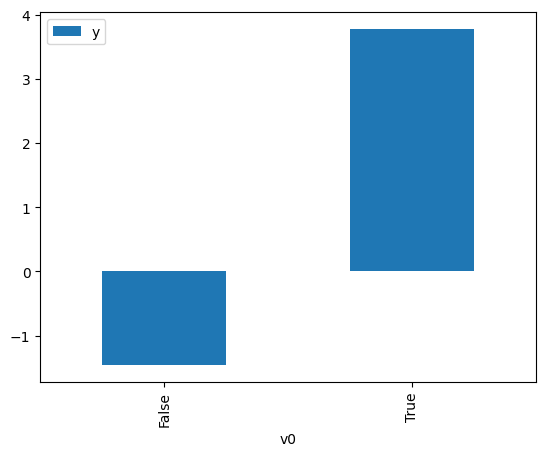

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

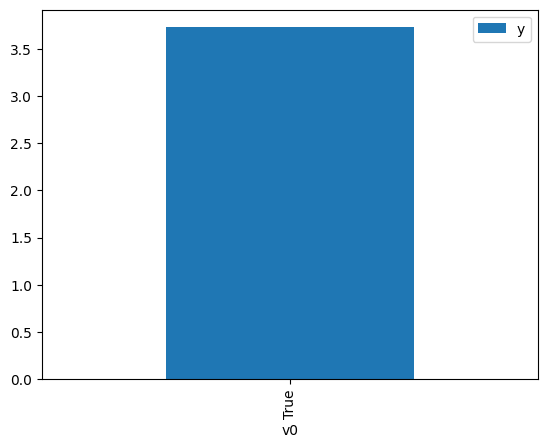

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.464397,False,-3.596732,0.995716,1.004302
1,-0.949306,False,-1.629671,0.898035,1.113542
2,-3.133813,False,-4.754921,0.998988,1.001013
3,-2.385485,False,-2.841521,0.994924,1.005102
4,0.467739,False,-0.303072,0.292009,3.424548
...,...,...,...,...,...
995,-0.980088,False,-1.242719,0.903965,1.106237
996,-1.409210,False,-0.497941,0.959655,1.042041
997,-0.641814,False,-0.023440,0.819255,1.220621
998,-1.157011,False,-0.581519,0.932408,1.072492


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.852539,True,2.242374,0.015878,62.980772
1,-1.684452,True,0.976851,0.022672,44.108002
2,-0.031701,True,4.263158,0.451827,2.213235
3,-1.852539,True,2.242374,0.015878,62.980772
4,0.720764,True,5.904678,0.807252,1.238770
...,...,...,...,...,...
995,0.034571,True,5.498146,0.487472,2.051400
996,-0.322492,True,3.572749,0.305449,3.273865
997,0.170548,True,5.009471,0.560607,1.783780
998,-0.870968,True,3.891278,0.118538,8.436112


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              5202.
Date:                Tue, 21 May 2024   Prob (F-statistic):                        0.00
Time:                        17:51:58   Log-Likelihood:                         -1388.6
No. Observations:                1000   AIC:                                      2781.
Df Residuals:                     998   BIC:                                      2791.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4490      0.022     65.193      0.000       1.405       1.493
x2             5.0889      0.066     76.632      0.000       4.959       5.219
==============================================================================
Omnibus:                        2.687   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.562
Skew:                          -0.096   Prob(JB):                        0.278
Kurtosis:                       3.157   Cond. No.                         2.99
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""